In [1]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
import pandas as pd
import numpy as np
import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac

from IPython import display

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
## -- Use last N points

## -- autencode to 2D

## -- Use as input for 

In [4]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.base import BaseEstimator, ClassifierMixin

In [5]:
class EncodingGenerator():
    def __init__(self, layers, n, dim):
        self.history = []
        self.layers = layers
        self.n = n
        self.dim = dim
        self._autoencoder = self._encoder()


    def _encoder(self):
        """
        Encode the input points
        
        Parameters
        ----------
        points: array
            Array of points to encode, shape of inputlayer.
        """
        
        self._input_layer = Input(shape = (int(self.n*self.dim),))
        self._encoded = Dense(self.layers[0][0], activation=self.layers[0][1])(self._input_layer)
        for layer in self.layers[1:]:
            self._encoded = Dense(layer[0], activation=layer[1])(self._encoded)

        self._decoded = Dense(self.layers[-2][0], activation=self.layers[-2][1])(self._encoded)
        for layer in self.layers[::-1][1:]:
            self._decoded = Dense(layer[0], activation=layer[1])(self._decoded)
        self._decoded = Dense(int(self.n*self.dim), activation='relu')(self._decoded)

        autoencoder = Model(self._input_layer, self._decoded)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

        return autoencoder

    def encode(self, points):
#         hist = np.vstack(self.history)[:,:-1]
        self._autoencoder.fit(points, points, verbose=False, epochs=10)
#         self._autoencoder.train_on_batch(points, points)
        self._encoder_model = Model(self._input_layer, self._encoded)
        
        return self._encoder_model.predict(points)

    
    def __call__(self, data):
        for point in data:
            self.history.append(point)
            if len(self.history) > self.n:
                last_n = np.vstack(self.history[-self.n:])
                X = last_n[:,:-1].reshape(1, int(self.n*self.dim))
                y = last_n[-1,-1]
                yield np.hstack([self.encode(X)[0], y])
            
            

KeyboardInterrupt: 

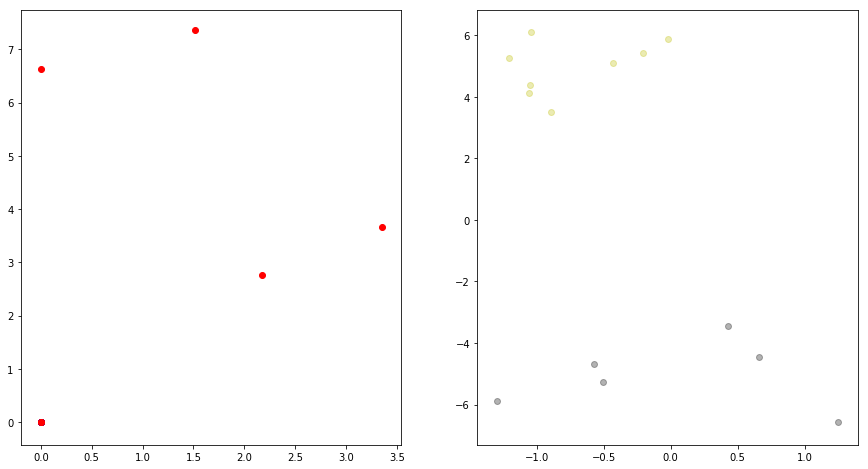

In [8]:
plt.figure(figsize=(15,8))
encoder = EncodingGenerator([(32, 'relu'), (8, 'relu'), (2, 'relu')], n=30, dim=2)
datastream = encoder(olac.data_generators.roving_balls())
i=0
for p in datastream:
    plt.subplot(121)
    plt.scatter(*p[:2].T, c= ['r','b'][int(p[-1])])
    
    plt.subplot(122)
    p2 = encoder.history[i]
    plt.scatter(*p2[:2].T, c= ['y','k'][int(p2[-1])], alpha=.3)
    i+=1
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [5]:
df = pd.read_csv('../data/raw/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
from sklearn.tree import DecisionTreeClassifier

In [7]:
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df[cols].values, df['Class'].values,
                                                                            test_size=0.33)

In [16]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
pred = tree.predict(X_test)

In [21]:
(pred == y_test).mean()

0.9991381786842861

In [22]:
df['Class'].mean()

0.001727485630620034

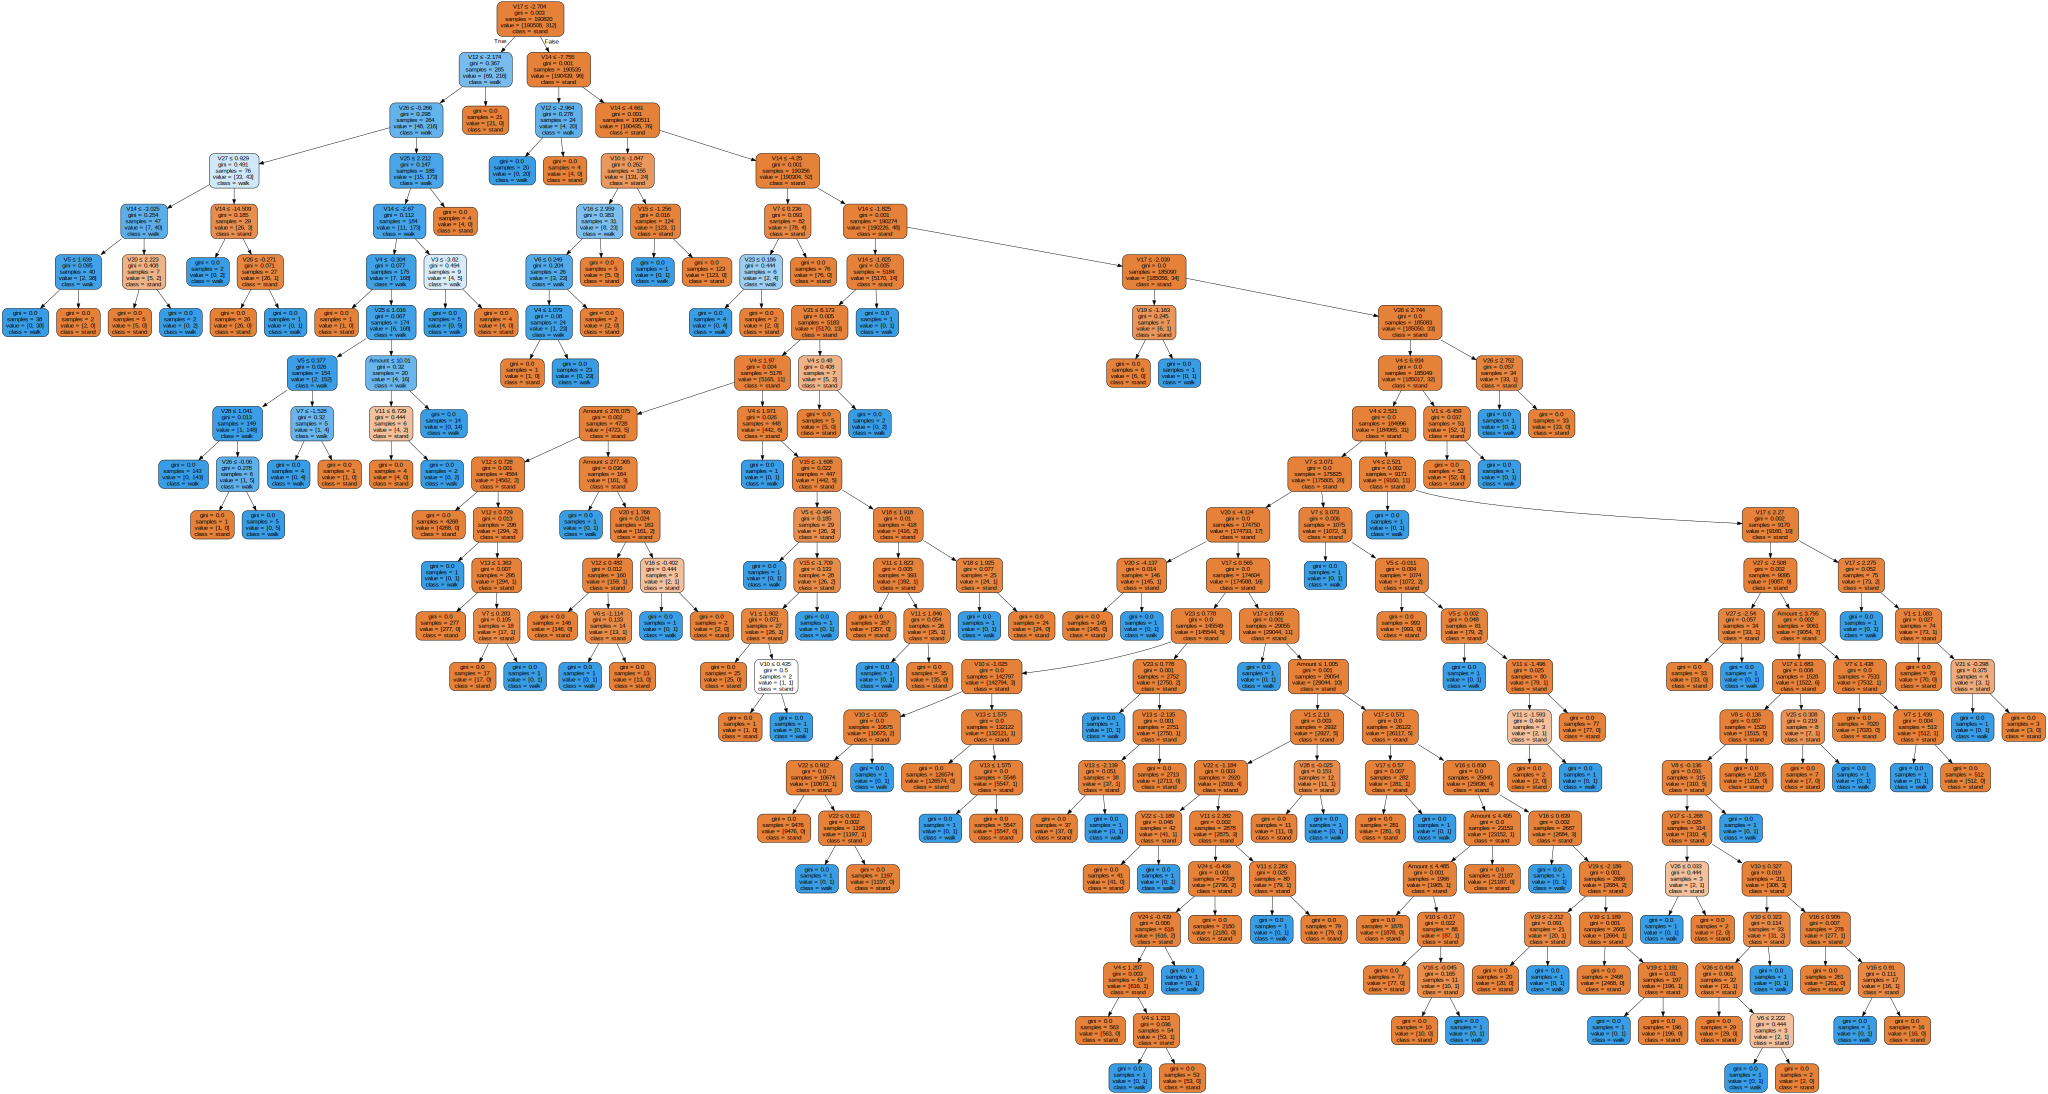

In [23]:
import graphviz 
label_dict= {0:'stand',1:'walk',2:'trot',3:'canter'}
dot_data = sklearn.tree.export_graphviz(tree, out_file=None, 
                         feature_names=cols,
                         class_names=label_dict,  
                         filled=True, rounded=True,  
                         special_characters=True)   
graph = graphviz.Source(dot_data) 
graph

In [24]:
for i, n in enumerate(tree.feature_importances_):
    print(n, cols[i])

0.005653049766072754 V1
0.0 V2
0.007134171841165769 V3
0.02047107977850165 V4
0.012591181117563011 V5
0.010564552133748292 V6
0.01996520693007601 V7
0.0033211611757437854 V8
0.0 V9
0.05117965401974274 V10
0.013857886605217303 V11
0.05593451617431911 V12
0.006587035033905513 V13
0.08772079143704037 V14
0.006902636056604986 V15
0.022006209975036935 V16
0.5355764988277006 V17
0.003187824913430805 V18
0.009167725748491734 V19
0.008807436704788747 V20
0.004212654235136794 V21
0.006412902183260378 V22
0.00749169833223327 V23
0.003210991001707623 V24
0.015907026902913398 V25
0.033911791248223855 V26
0.03538581140080468 V27
0.0034563626160010433 V28
0.009382143840568858 Amount


In [7]:
n_points = 5000
imb_contam = 0.1  # contamination fraction

n_points_0 = int(np.round((1-imb_contam)*n_points))
n_points_1 = int(np.round(imb_contam*n_points))

X_df = df[['Amount'] + [f'V{i+1}' for i in range(28)]]
y = df['Class']

# choose the indices
df_inds_0 = np.random.choice(y[y==0].index, size=(n_points_0,))
df_inds_1 = np.random.choice(
    y[y==1].index, 
    size=(n_points_1,), 
    replace=(n_points_1 > y.sum())
)
df_inds = np.hstack([df_inds_0, df_inds_1]) 
np.random.shuffle(df_inds)

# set up the array
cc = np.array(list(olac.data_generators.dynamify_data(
    X_df.iloc[df_inds], 
    y.iloc[df_inds], 
    transition_rate=0.001, 
)))

In [8]:
df_col = df.columns.values
# list(df_col[1:-1])

KeyboardInterrupt: 

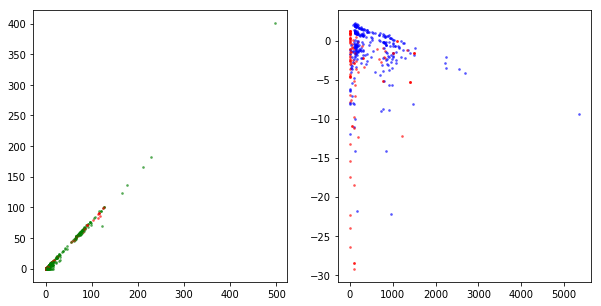

In [83]:
plt.figure(figsize=(10,5))
encoder = EncodingGenerator([(32, 'relu'), (8, 'relu'), (2, 'relu')], n=1, dim=29)
# datastream = encoder(olac.data_generators.generator_from_csv('../data/raw/creditcard.csv',
#                                                              list(df_col[1:-1]), label_column=df_col[-1]))
datastream = encoder(cc)
i=0
for p in datastream:
    plt.subplot(121)
    plt.scatter(*p[:2].T, c= ['g','r'][int(p[-1])], alpha=.5, s=3)
    
    plt.subplot(122)
    p2 = encoder.history[i]
    plt.scatter(*p2[:2].T, c= ['b','r'][int(p2[-1])], alpha=.5, s=3)
    i+=1
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Test the pipeline

In [22]:
# -- using the roving balls dataset generator
# data_generator = olac.data_generators.roving_balls(steps=4000, radius=1)

encoder = EncodingGenerator([(32, 'relu'), (8, 'relu'), (2, 'relu')], n=10, dim=2)
# datastream = list(encoder(cc))
datastream = list(encoder(olac.data_generators.roving_balls(steps=2000)))

# -- using the multilayer perceptron classifier from sklearn
model = MLPClassifier((63,32,))
# -- using the online predictor algorithm
predictor = olac.pipeline.OnlinePredictor(verbose=True)
# -- using a simple threshold labeller
labeller = olac.pipeline.ThresholdLabeller(threshold=30, prob=0.8, verbose=True)

# -- Define the pipeline using the above defined elements
pipeline = olac.pipeline.Pipeline(data_generator=datastream, 
                                  model=model,
                                  predictor=predictor,
                                  labeller=labeller)


In [23]:
eval_set, train_set = pipeline.run()

Labeller:	Threshold met, 1216 new points available in queue
Labeller:	Labelled 965 new points
Labeller:	Threshold met, 104 new points available in queue
Predictor:	965 new points available, updating...
Labeller:	Labelled 89 new points
Predictor:	89 new points available, updating...
Labeller:	Threshold met, 118 new points available in queue
Labeller:	Labelled 89 new points
Predictor:	89 new points available, updating...
Labeller:	Threshold met, 61 new points available in queue
Labeller:	Labelled 51 new points
Labeller:	Threshold met, 120 new points available in queue
Predictor:	51 new points available, updating...
Labeller:	Labelled 98 new points
Predictor:	98 new points available, updating...
Labeller:	Threshold met, 63 new points available in queue
Labeller:	Labelled 55 new points
Predictor:	55 new points available, updating...
Labeller:	Threshold met, 46 new points available in queue
Labeller:	Labelled 52 new points
Labeller:	Threshold met, 229 new points available in queue
Predictor

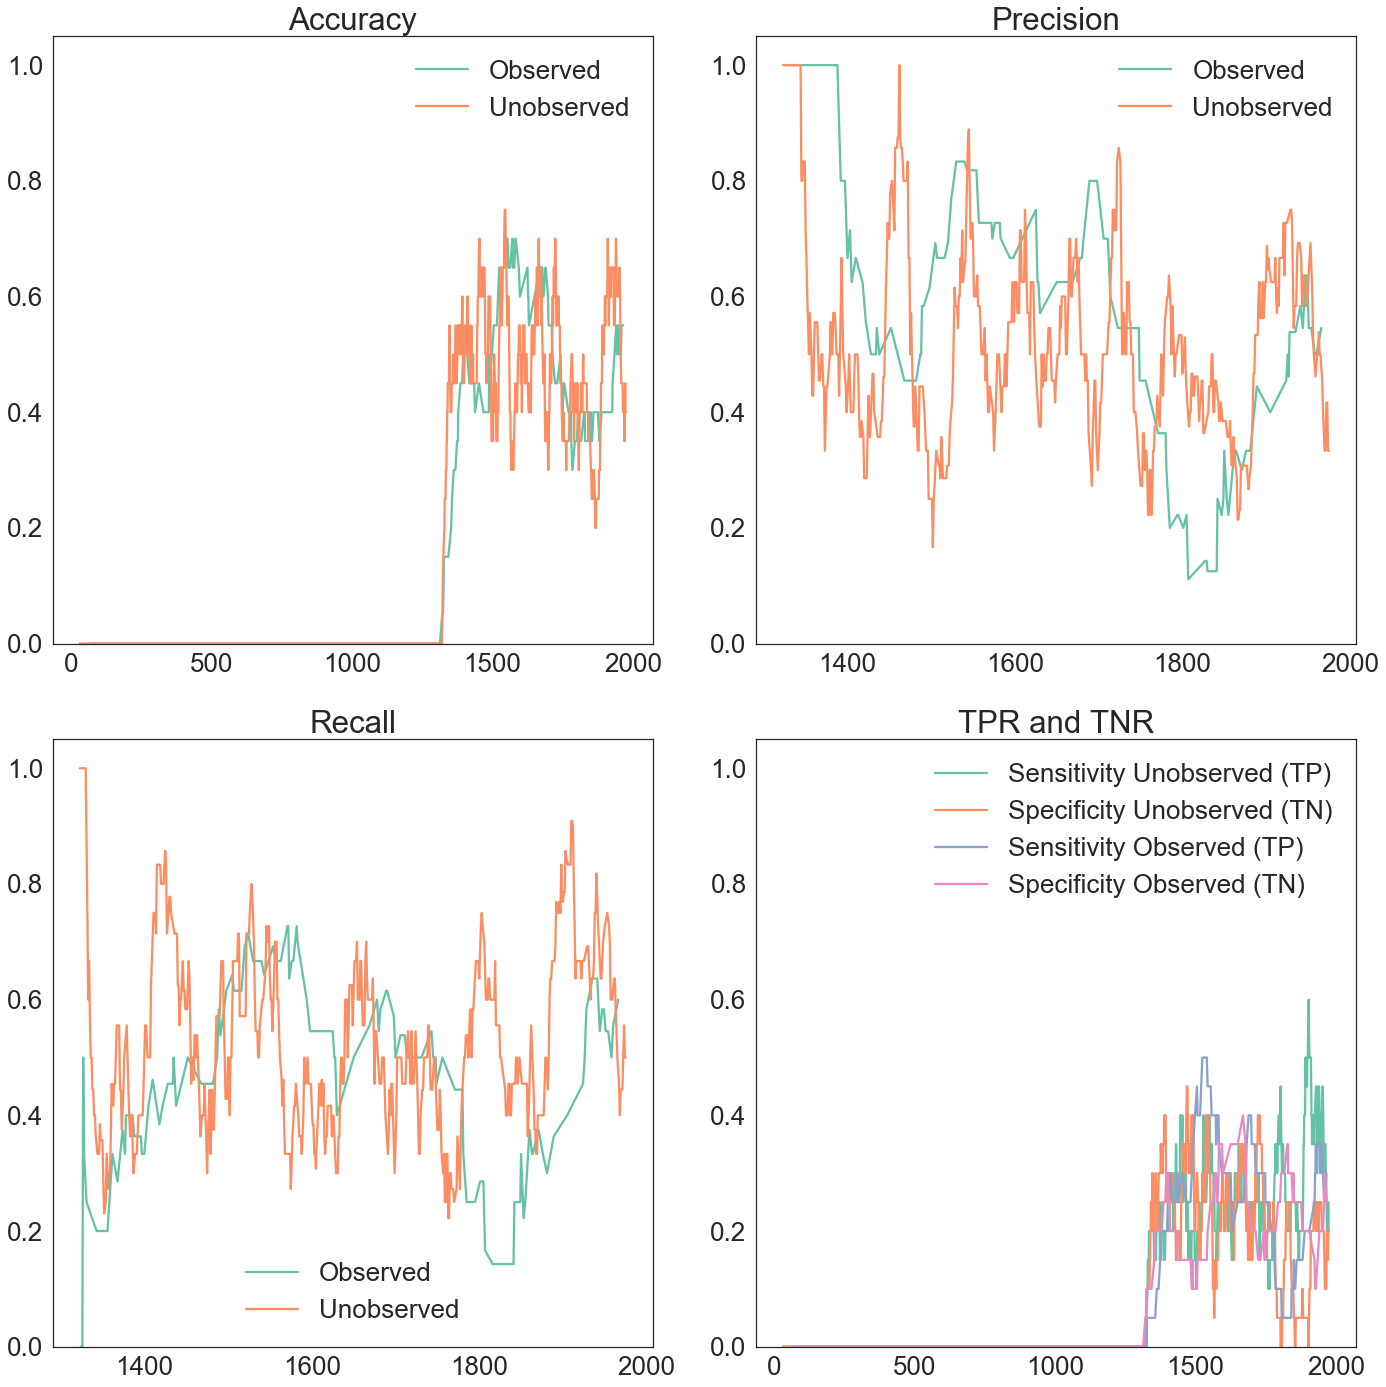

In [24]:
olac.vis.performance(eval_set, train_set, 20)

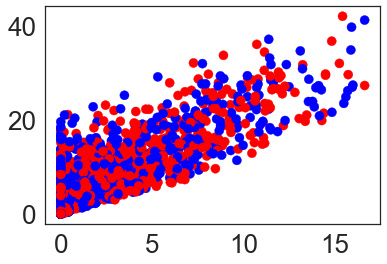

In [36]:
plt.scatter(*np.array(datastream)[:,:2].T, c = np.array(['b','r'])[np.array(datastream, dtype=int)[:,-1]])

In [37]:
#--- satellite clusters

In [52]:
# -- using the roving balls dataset generator
# data_generator = olac.data_generators.roving_balls(steps=4000, radius=1)

encoder = EncodingGenerator([(32, 'relu'), (8, 'relu'), (2, 'relu')], n=10, dim=2)
# datastream = list(encoder(cc))
datastream = list(encoder(olac.data_generators.satellites(n_points=1000, n_satellites=3, contamination=0.4)))

# -- using the multilayer perceptron classifier from sklearn
model = MLPClassifier((63,32,))
# -- using the online predictor algorithm
predictor = olac.pipeline.OnlinePredictor(verbose=True)
# -- using a simple threshold labeller
labeller = olac.pipeline.ThresholdLabeller(threshold=30, prob=0.8, verbose=True)

# -- Define the pipeline using the above defined elements
pipeline = olac.pipeline.Pipeline(data_generator=datastream, 
                                  model=model,
                                  predictor=predictor,
                                  labeller=labeller)


In [53]:
eval_set, train_set = pipeline.run()

Labeller:	Threshold met, 634 new points available in queue
Labeller:	Labelled 531 new points
Predictor:	531 new points available, updating...
Labeller:	Threshold met, 118 new points available in queue
Labeller:	Labelled 100 new points
Predictor:	100 new points available, updating...
Labeller:	Threshold met, 99 new points available in queue
Labeller:	Labelled 81 new points
Predictor:	81 new points available, updating...
Labeller:	Threshold met, 43 new points available in queue
Labeller:	Labelled 35 new points
Labeller:	Threshold met, 49 new points available in queue
Predictor:	35 new points available, updating...
Labeller:	Labelled 41 new points
Predictor:	41 new points available, updating...


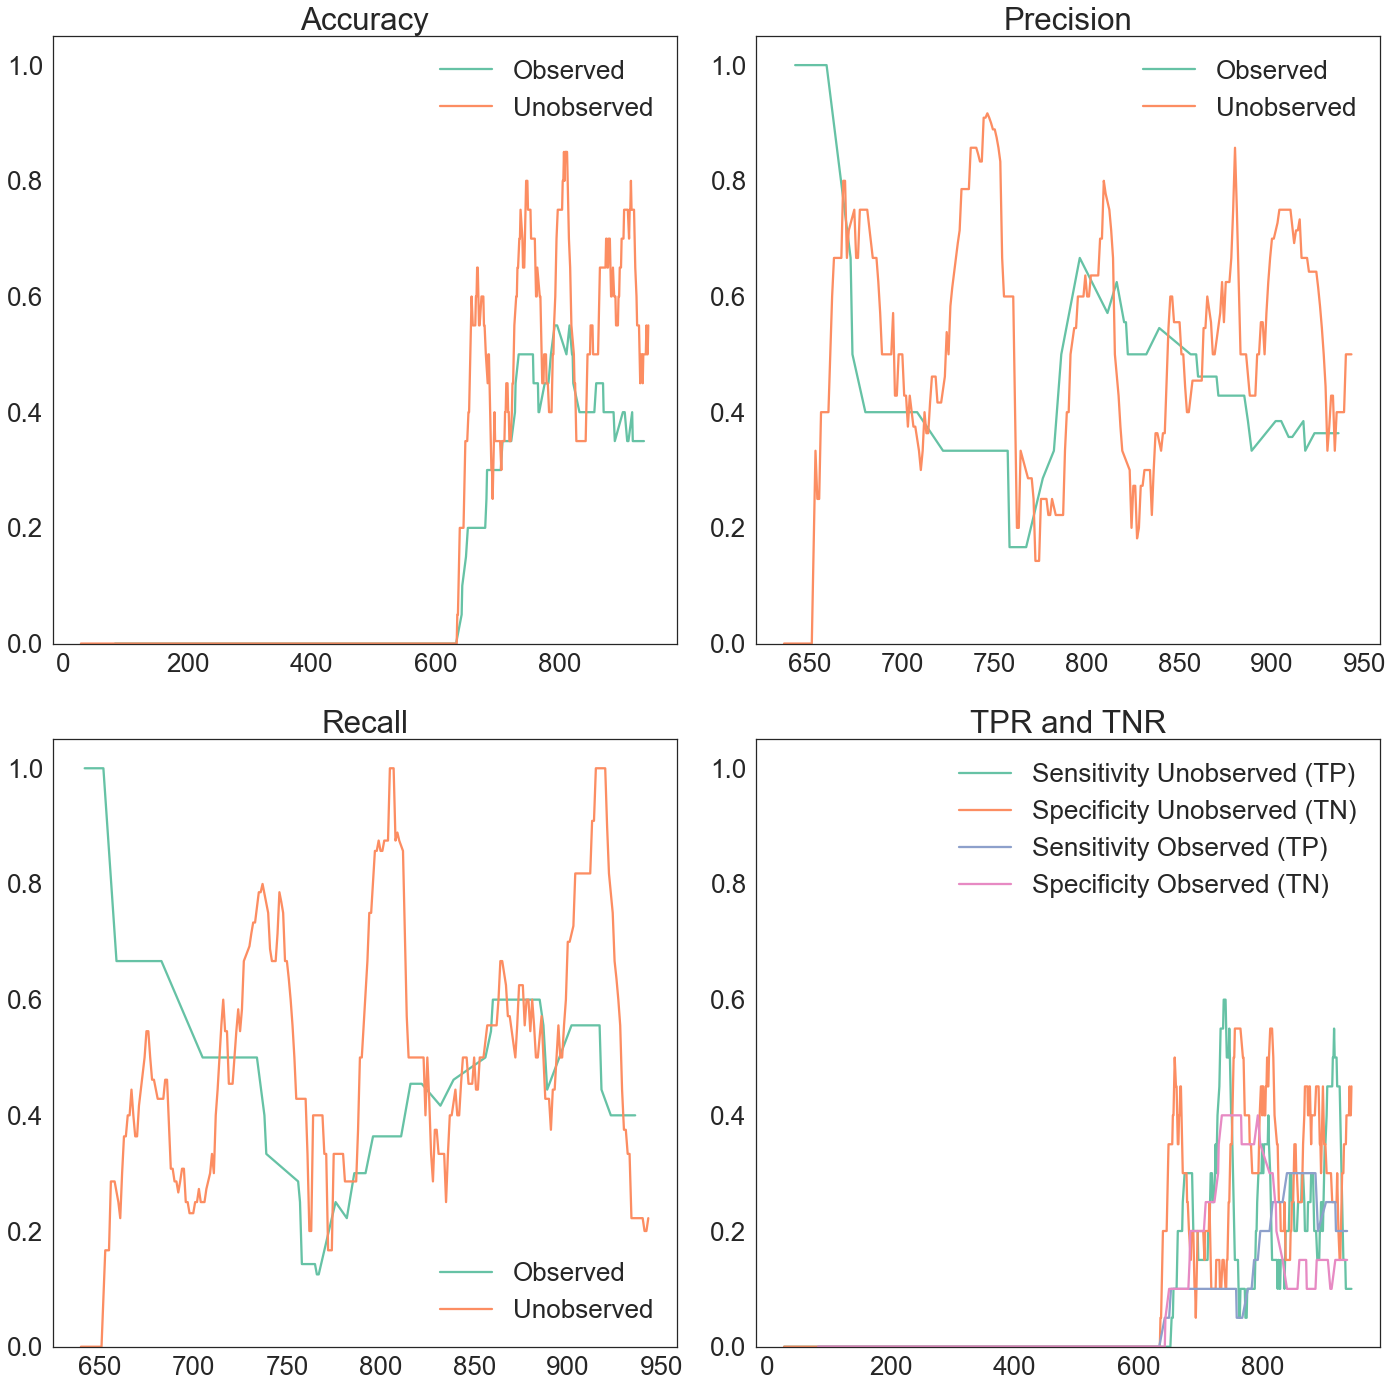

In [54]:
olac.vis.performance(eval_set, train_set, 20)

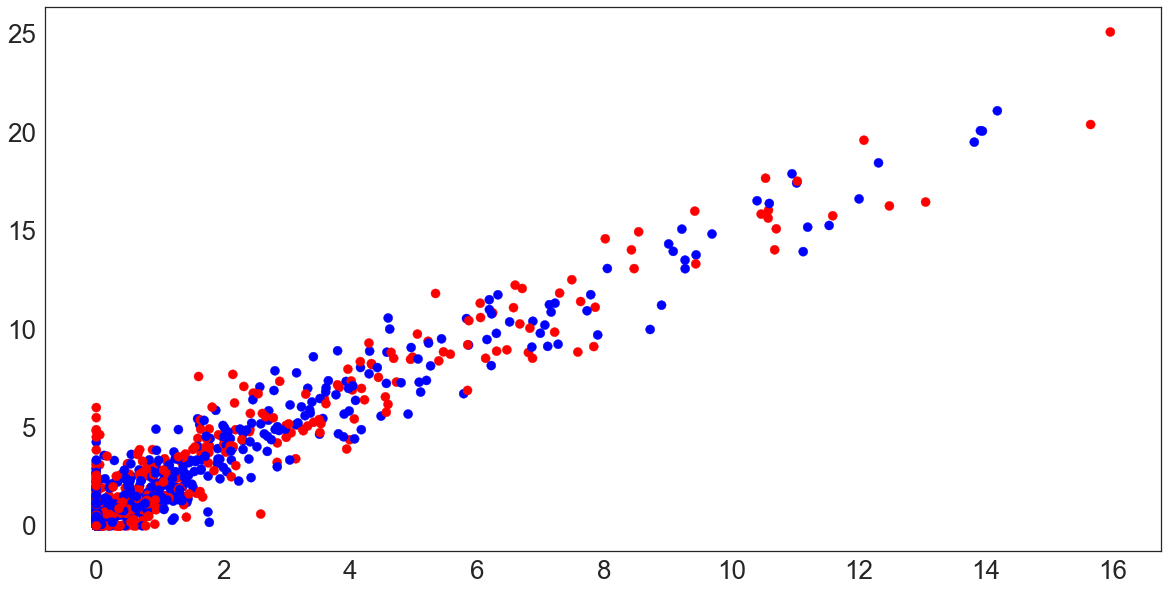

In [55]:
plt.figure(figsize=(20,10))
plt.scatter(*np.array(datastream)[:,:2].T, c = np.array(['b','r'])[np.array(datastream, dtype=int)[:,-1]])

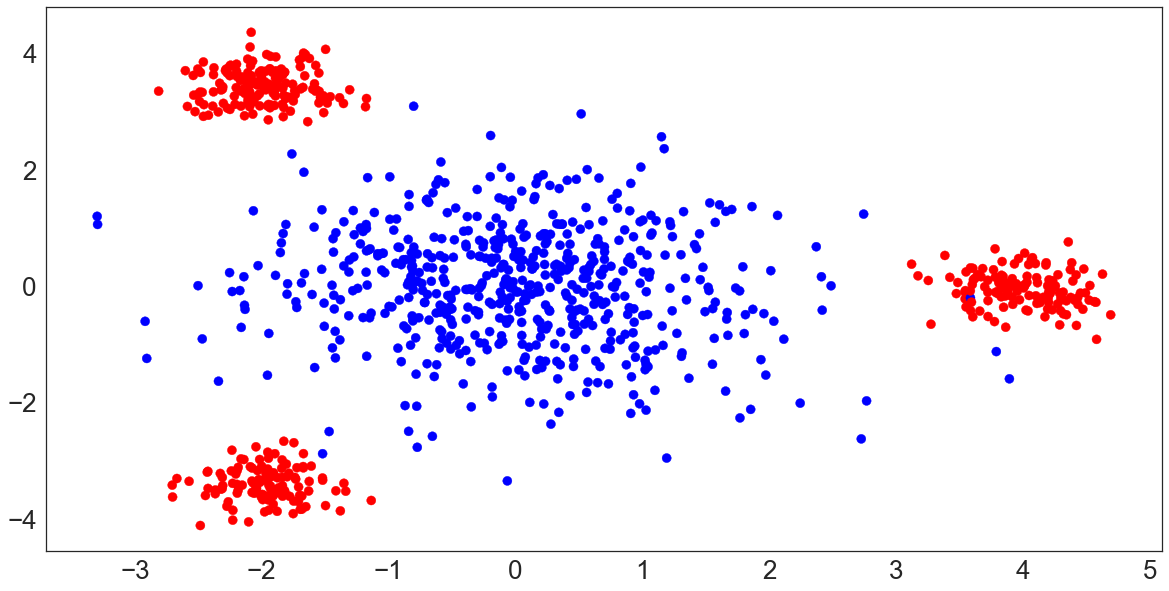

In [56]:
X = np.vstack(encoder.history)
plt.figure(figsize=(20,10))
plt.scatter(*X[:,:2].T, c= np.array(['b','r'])[X[:,-1].astype(int)])